In [1]:
# Titanic Survival Prediction: ML Model Analysis

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("="*60)

Libraries imported successfully!


In [2]:
# 1. DATA LOADING AND EXPLORATION
print("1. LOADING AND EXPLORING THE TITANIC DATASET")
print("="*60)

# Load the dataset
df = pd.read_csv('Titanic-Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")

# Display basic information
print("\nFirst 10 rows:")
print(df.head(10))

print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print("\nTarget variable distribution:")
survival_counts = df['Survived'].value_counts()
print(survival_counts)
print(f"Survival rate: {df['Survived'].mean():.2%}")

print("\nBasic statistics:")
print(df.describe())

1. LOADING AND EXPLORING THE TITANIC DATASET
Dataset shape: (891, 12)

Column names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First 10 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   


In [3]:
# 2. DATA PREPROCESSING
print("\n" + "="*60)
print("2. DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
data = df.copy()

# Handle missing values
print("Handling missing values...")

# Age: Fill with median
data['Age'].fillna(data['Age'].median(), inplace=True)

# Embarked: Fill with mode (most common)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Cabin: Create a binary feature for having cabin info
data['Has_Cabin'] = data['Cabin'].notna().astype(int)

# Drop unnecessary columns
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
data = data.drop(columns=columns_to_drop)

print(f"Columns after dropping unnecessary features: {list(data.columns)}")

# Encode categorical variables
label_encoders = {}

# Sex: male=1, female=0
data['Sex'] = data['Sex'].map({'male': 1, 'female': 0})

# Embarked: S=0, C=1, Q=2
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
data['Embarked'] = data['Embarked'].map(embarked_mapping)

print("\nCategorical encoding completed:")
print(f"Sex encoding: female=0, male=1")
print(f"Embarked encoding: S=0, C=1, Q=2")

# Create additional features
print("\nCreating additional features:")
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1
data['Is_Alone'] = (data['Family_Size'] == 1).astype(int)
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100],
                          labels=['Child', 'Teen', 'Adult', 'Middle_Age', 'Senior'])
data['Age_Group'] = LabelEncoder().fit_transform(data['Age_Group'])

print("New features created:")
print("- Family_Size: SibSp + Parch + 1")
print("- Is_Alone: 1 if traveling alone, 0 otherwise")
print("- Age_Group: Age categories encoded as numbers")

print(f"\nFinal dataset shape: {data.shape}")
print(f"Missing values after preprocessing: {data.isnull().sum().sum()}")

# Display preprocessed data
print("\nPreprocessed data sample:")
print(data.head())


2. DATA PREPROCESSING
Handling missing values...
Columns after dropping unnecessary features: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Has_Cabin']

Categorical encoding completed:
Sex encoding: female=0, male=1
Embarked encoding: S=0, C=1, Q=2

Creating additional features:
New features created:
- Family_Size: SibSp + Parch + 1
- Is_Alone: 1 if traveling alone, 0 otherwise
- Age_Group: Age categories encoded as numbers

Final dataset shape: (891, 12)
Missing values after preprocessing: 0

Preprocessed data sample:
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Has_Cabin  \
0         0       3    1  22.0      1      0   7.2500         0          0   
1         1       1    0  38.0      1      0  71.2833         1          1   
2         1       3    0  26.0      0      0   7.9250         0          0   
3         1       1    0  35.0      1      0  53.1000         0          1   
4         0       3    1  35.0      0      0   8.0500 

In [4]:
# 3. FEATURE SELECTION AND DATA SPLITTING
print("\n" + "="*60)
print("3. FEATURE SELECTION AND DATA SPLITTING")
print("="*60)

# Separate features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

print(f"Features: {list(X.columns)}")
print(f"Number of features: {X.shape[1]}")
print(f"Target distribution: {dict(y.value_counts())}")

# Display feature correlation with target
print("\nFeature correlation with Survived:")
correlations = X.corrwith(y).sort_values(ascending=False)
for feature, corr in correlations.items():
    print(f"{feature:15}: {corr:6.3f}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set survival rate: {y_train.mean():.2%}")
print(f"Test set survival rate: {y_test.mean():.2%}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed using StandardScaler")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")


3. FEATURE SELECTION AND DATA SPLITTING
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Has_Cabin', 'Family_Size', 'Is_Alone', 'Age_Group']
Number of features: 11
Target distribution: {0: np.int64(549), 1: np.int64(342)}

Feature correlation with Survived:
Has_Cabin      :  0.317
Fare           :  0.257
Embarked       :  0.107
Parch          :  0.082
Age_Group      :  0.040
Family_Size    :  0.017
SibSp          : -0.035
Age            : -0.065
Is_Alone       : -0.203
Pclass         : -0.338
Sex            : -0.543

Data split completed:
Training set: 712 samples
Test set: 179 samples
Training set survival rate: 38.34%
Test set survival rate: 38.55%

Feature scaling completed using StandardScaler
Scaled training data shape: (712, 11)
Scaled test data shape: (179, 11)


In [5]:
# 4. LOGISTIC REGRESSION MODEL
print("\n" + "="*60)
print("4. LOGISTIC REGRESSION MODEL")
print("="*60)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)
lr_precision = precision_score(y_test, lr_test_pred)
lr_recall = recall_score(y_test, lr_test_pred)
lr_f1 = f1_score(y_test, lr_test_pred)
lr_auc = roc_auc_score(y_test, lr_test_proba)

print("LOGISTIC REGRESSION RESULTS:")
print("-" * 40)
print(f"Training Accuracy: {lr_train_acc:.4f}")
print(f"Testing Accuracy:  {lr_test_acc:.4f}")
print(f"Precision:         {lr_precision:.4f}")
print(f"Recall:            {lr_recall:.4f}")
print(f"F1-Score:          {lr_f1:.4f}")
print(f"AUC-ROC:           {lr_auc:.4f}")

# Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_test_pred)
print(f"\nConfusion Matrix:")
print(lr_cm)

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, lr_test_pred, target_names=['Did not survive', 'Survived']))

# Feature importance (coefficients)
feature_names = X.columns.tolist()
lr_coefficients = lr_model.coef_[0]
lr_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefficients,
    'Absolute_Coefficient': np.abs(lr_coefficients)
}).sort_values('Absolute_Coefficient', ascending=False)

print(f"\nFeature Importance (Logistic Regression Coefficients):")
print(lr_feature_importance)


4. LOGISTIC REGRESSION MODEL
LOGISTIC REGRESSION RESULTS:
----------------------------------------
Training Accuracy: 0.8034
Testing Accuracy:  0.8101
Precision:         0.7692
Recall:            0.7246
F1-Score:          0.7463
AUC-ROC:           0.8472

Confusion Matrix:
[[95 15]
 [19 50]]

Detailed Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.83      0.86      0.85       110
       Survived       0.77      0.72      0.75        69

       accuracy                           0.81       179
      macro avg       0.80      0.79      0.80       179
   weighted avg       0.81      0.81      0.81       179


Feature Importance (Logistic Regression Coefficients):
        Feature  Coefficient  Absolute_Coefficient
1           Sex    -1.239052              1.239052
0        Pclass    -0.655679              0.655679
2           Age    -0.485311              0.485311
7     Has_Cabin     0.374388              0.374388
9      Is_Alone  

In [6]:
# 5. SUPPORT VECTOR MACHINE MODEL
print("\n" + "="*60)
print("5. SUPPORT VECTOR MACHINE MODEL")
print("="*60)

# Train SVM with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)
svm_train_proba = svm_model.predict_proba(X_train_scaled)[:, 1]
svm_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_precision = precision_score(y_test, svm_test_pred)
svm_recall = recall_score(y_test, svm_test_pred)
svm_f1 = f1_score(y_test, svm_test_pred)
svm_auc = roc_auc_score(y_test, svm_test_proba)

print("SVM RESULTS:")
print("-" * 40)
print(f"Training Accuracy: {svm_train_acc:.4f}")
print(f"Testing Accuracy:  {svm_test_acc:.4f}")
print(f"Precision:         {svm_precision:.4f}")
print(f"Recall:            {svm_recall:.4f}")
print(f"F1-Score:          {svm_f1:.4f}")
print(f"AUC-ROC:           {svm_auc:.4f}")

# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_test_pred)
print(f"\nConfusion Matrix:")
print(svm_cm)

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, svm_test_pred, target_names=['Did not survive', 'Survived']))

# Model parameters
print(f"\nSVM Model Parameters:")
print(f"Kernel: {svm_model.kernel}")
print(f"C (Regularization): {svm_model.C}")
print(f"Gamma: {svm_model.gamma}")
print(f"Number of support vectors: {svm_model.n_support_}")


5. SUPPORT VECTOR MACHINE MODEL
SVM RESULTS:
----------------------------------------
Training Accuracy: 0.8455
Testing Accuracy:  0.8268
Precision:         0.8276
Recall:            0.6957
F1-Score:          0.7559
AUC-ROC:           0.8383

Confusion Matrix:
[[100  10]
 [ 21  48]]

Detailed Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.83      0.91      0.87       110
       Survived       0.83      0.70      0.76        69

       accuracy                           0.83       179
      macro avg       0.83      0.80      0.81       179
   weighted avg       0.83      0.83      0.82       179


SVM Model Parameters:
Kernel: rbf
C (Regularization): 1.0
Gamma: scale
Number of support vectors: [171 166]


In [7]:
# 6. PRINCIPAL COMPONENT ANALYSIS (PCA)
print("\n" + "="*60)
print("6. PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*60)

# Apply PCA to reduce dimensionality
print("Analyzing different numbers of PCA components...")

pca_components_range = range(2, len(X.columns) + 1)
pca_results = {}

for n_comp in pca_components_range:
    pca = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Calculate explained variance ratio
    explained_var = pca.explained_variance_ratio_
    total_var = sum(explained_var)

    pca_results[n_comp] = {
        'pca': pca,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
        'explained_var': explained_var,
        'total_var': total_var
    }

    print(f"\nPCA with {n_comp} components:")
    print(f"Explained variance ratio: {np.round(explained_var, 4)}")
    print(f"Total explained variance: {total_var:.4f}")

# Choose optimal number of components (>= 90% variance or 95% of features)
optimal_components = None
for n_comp in pca_components_range:
    if pca_results[n_comp]['total_var'] >= 0.90:
        optimal_components = n_comp
        break

if optimal_components is None:
    optimal_components = max(2, len(X.columns) - 2)  # Use n-2 components as fallback

print(f"\n" + "="*40)
print(f"SELECTED OPTIMAL PCA COMPONENTS: {optimal_components}")
print(f"Explains {pca_results[optimal_components]['total_var']:.4f} of total variance")
print("="*40)

# Get the PCA transformed data
X_train_pca = pca_results[optimal_components]['X_train_pca']
X_test_pca = pca_results[optimal_components]['X_test_pca']
optimal_pca = pca_results[optimal_components]['pca']

# Show PCA components (loadings)
print(f"\nPCA Component Loadings:")
components_df = pd.DataFrame(
    optimal_pca.components_.T,
    columns=[f'PC{i+1}' for i in range(optimal_components)],
    index=feature_names
)
print(components_df.round(4))

print(f"\nPCA transformation completed:")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Dimensionality reduction: {X_train_scaled.shape[1] - X_train_pca.shape[1]} features removed")


6. PRINCIPAL COMPONENT ANALYSIS (PCA)
Analyzing different numbers of PCA components...

PCA with 2 components:
Explained variance ratio: [0.2951 0.2186]
Total explained variance: 0.5138

PCA with 3 components:
Explained variance ratio: [0.2951 0.2186 0.1069]
Total explained variance: 0.6206

PCA with 4 components:
Explained variance ratio: [0.2951 0.2186 0.1069 0.0913]
Total explained variance: 0.7120

PCA with 5 components:
Explained variance ratio: [0.2951 0.2186 0.1069 0.0913 0.076 ]
Total explained variance: 0.7880

PCA with 6 components:
Explained variance ratio: [0.2951 0.2186 0.1069 0.0913 0.076  0.0593]
Total explained variance: 0.8473

PCA with 7 components:
Explained variance ratio: [0.2951 0.2186 0.1069 0.0913 0.076  0.0593 0.0509]
Total explained variance: 0.8981

PCA with 8 components:
Explained variance ratio: [0.2951 0.2186 0.1069 0.0913 0.076  0.0593 0.0509 0.0469]
Total explained variance: 0.9450

PCA with 9 components:
Explained variance ratio: [0.2951 0.2186 0.1069 

In [8]:
# 7. MODELS WITH PCA
print("\n" + "="*60)
print("7. MODELS WITH PCA")
print("="*60)

# 7a. Logistic Regression with PCA
print("7A. LOGISTIC REGRESSION + PCA")
print("-" * 40)

lr_pca_model = LogisticRegression(random_state=42, max_iter=1000)
lr_pca_model.fit(X_train_pca, y_train)

# Predictions
lr_pca_train_pred = lr_pca_model.predict(X_train_pca)
lr_pca_test_pred = lr_pca_model.predict(X_test_pca)
lr_pca_train_proba = lr_pca_model.predict_proba(X_train_pca)[:, 1]
lr_pca_test_proba = lr_pca_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
lr_pca_train_acc = accuracy_score(y_train, lr_pca_train_pred)
lr_pca_test_acc = accuracy_score(y_test, lr_pca_test_pred)
lr_pca_precision = precision_score(y_test, lr_pca_test_pred)
lr_pca_recall = recall_score(y_test, lr_pca_test_pred)
lr_pca_f1 = f1_score(y_test, lr_pca_test_pred)
lr_pca_auc = roc_auc_score(y_test, lr_pca_test_proba)

print("LOGISTIC REGRESSION + PCA RESULTS:")
print(f"Training Accuracy: {lr_pca_train_acc:.4f}")
print(f"Testing Accuracy:  {lr_pca_test_acc:.4f}")
print(f"Precision:         {lr_pca_precision:.4f}")
print(f"Recall:            {lr_pca_recall:.4f}")
print(f"F1-Score:          {lr_pca_f1:.4f}")
print(f"AUC-ROC:           {lr_pca_auc:.4f}")

lr_pca_cm = confusion_matrix(y_test, lr_pca_test_pred)
print(f"\nConfusion Matrix:")
print(lr_pca_cm)

print(f"\nClassification Report:")
print(classification_report(y_test, lr_pca_test_pred, target_names=['Did not survive', 'Survived']))

# 7b. SVM with PCA
print("\n7B. SVM + PCA")
print("-" * 40)

svm_pca_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# Predictions
svm_pca_train_pred = svm_pca_model.predict(X_train_pca)
svm_pca_test_pred = svm_pca_model.predict(X_test_pca)
svm_pca_train_proba = svm_pca_model.predict_proba(X_train_pca)[:, 1]
svm_pca_test_proba = svm_pca_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
svm_pca_train_acc = accuracy_score(y_train, svm_pca_train_pred)
svm_pca_test_acc = accuracy_score(y_test, svm_pca_test_pred)
svm_pca_precision = precision_score(y_test, svm_pca_test_pred)
svm_pca_recall = recall_score(y_test, svm_pca_test_pred)
svm_pca_f1 = f1_score(y_test, svm_pca_test_pred)
svm_pca_auc = roc_auc_score(y_test, svm_pca_test_proba)

print("SVM + PCA RESULTS:")
print(f"Training Accuracy: {svm_pca_train_acc:.4f}")
print(f"Testing Accuracy:  {svm_pca_test_acc:.4f}")
print(f"Precision:         {svm_pca_precision:.4f}")
print(f"Recall:            {svm_pca_recall:.4f}")
print(f"F1-Score:          {svm_pca_f1:.4f}")
print(f"AUC-ROC:           {svm_pca_auc:.4f}")

svm_pca_cm = confusion_matrix(y_test, svm_pca_test_pred)
print(f"\nConfusion Matrix:")
print(svm_pca_cm)

print(f"\nClassification Report:")
print(classification_report(y_test, svm_pca_test_pred, target_names=['Did not survive', 'Survived']))


7. MODELS WITH PCA
7A. LOGISTIC REGRESSION + PCA
----------------------------------------
LOGISTIC REGRESSION + PCA RESULTS:
Training Accuracy: 0.8034
Testing Accuracy:  0.7989
Precision:         0.7391
Recall:            0.7391
F1-Score:          0.7391
AUC-ROC:           0.8444

Confusion Matrix:
[[92 18]
 [18 51]]

Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.84      0.84      0.84       110
       Survived       0.74      0.74      0.74        69

       accuracy                           0.80       179
      macro avg       0.79      0.79      0.79       179
   weighted avg       0.80      0.80      0.80       179


7B. SVM + PCA
----------------------------------------
SVM + PCA RESULTS:
Training Accuracy: 0.8357
Testing Accuracy:  0.8324
Precision:         0.8095
Recall:            0.7391
F1-Score:          0.7727
AUC-ROC:           0.8420

Confusion Matrix:
[[98 12]
 [18 51]]

Classification Report:
                 p

In [9]:
# 8. COMPREHENSIVE MODEL COMPARISON
print("\n" + "="*60)
print("8. COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Compile all model results
models_detailed = {
    'Logistic Regression': {
        'train_acc': lr_train_acc, 'test_acc': lr_test_acc, 'precision': lr_precision,
        'recall': lr_recall, 'f1': lr_f1, 'auc': lr_auc, 'confusion_matrix': lr_cm,
        'features': f'All {len(X.columns)} features'
    },
    'SVM': {
        'train_acc': svm_train_acc, 'test_acc': svm_test_acc, 'precision': svm_precision,
        'recall': svm_recall, 'f1': svm_f1, 'auc': svm_auc, 'confusion_matrix': svm_cm,
        'features': f'All {len(X.columns)} features'
    },
    'Logistic Regression + PCA': {
        'train_acc': lr_pca_train_acc, 'test_acc': lr_pca_test_acc, 'precision': lr_pca_precision,
        'recall': lr_pca_recall, 'f1': lr_pca_f1, 'auc': lr_pca_auc, 'confusion_matrix': lr_pca_cm,
        'features': f'{optimal_components} PCA components'
    },
    'SVM + PCA': {
        'train_acc': svm_pca_train_acc, 'test_acc': svm_pca_test_acc, 'precision': svm_pca_precision,
        'recall': svm_pca_recall, 'f1': svm_pca_f1, 'auc': svm_pca_auc, 'confusion_matrix': svm_pca_cm,
        'features': f'{optimal_components} PCA components'
    }
}

# Create comprehensive comparison DataFrame
model_results = []
for model_name, metrics in models_detailed.items():
    model_results.append({
        'Model': model_name,
        'Training Accuracy': metrics['train_acc'],
        'Testing Accuracy': metrics['test_acc'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC-ROC': metrics['auc'],
        'Features': metrics['features']
    })

results_df = pd.DataFrame(model_results)

print("MODEL PERFORMANCE COMPARISON:")
print("=" * 80)
print(results_df.round(4).to_string(index=False))

# Calculate overfitting
results_df['Overfitting (Train-Test)'] = results_df['Training Accuracy'] - results_df['Testing Accuracy']

print("\nOVERFITTING ANALYSIS:")
print("-" * 40)
overfitting_df = results_df[['Model', 'Training Accuracy', 'Testing Accuracy', 'Overfitting (Train-Test)']]
print(overfitting_df.round(4).to_string(index=False))

# Identify best model
best_model_idx = results_df['Testing Accuracy'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model_acc = results_df.loc[best_model_idx, 'Testing Accuracy']
best_model_f1 = results_df.loc[best_model_idx, 'F1-Score']

print("\n" + "🏆" * 20)
print(f"BEST MODEL: {best_model_name}")
print(f"Testing Accuracy: {best_model_acc:.4f}")
print(f"F1-Score: {best_model_f1:.4f}")
print("🏆" * 20)

# Model ranking
print("\nMODEL RANKING (by Testing Accuracy):")
print("-" * 50)
sorted_results = results_df.sort_values('Testing Accuracy', ascending=False)
for idx, (_, row) in enumerate(sorted_results.iterrows(), 1):
    print(f"{idx}. {row['Model']}: {row['Testing Accuracy']:.4f}")


8. COMPREHENSIVE MODEL COMPARISON
MODEL PERFORMANCE COMPARISON:
                    Model  Training Accuracy  Testing Accuracy  Precision  Recall  F1-Score  AUC-ROC         Features
      Logistic Regression             0.8034            0.8101     0.7692  0.7246    0.7463   0.8472  All 11 features
                      SVM             0.8455            0.8268     0.8276  0.6957    0.7559   0.8383  All 11 features
Logistic Regression + PCA             0.8034            0.7989     0.7391  0.7391    0.7391   0.8444 8 PCA components
                SVM + PCA             0.8357            0.8324     0.8095  0.7391    0.7727   0.8420 8 PCA components

OVERFITTING ANALYSIS:
----------------------------------------
                    Model  Training Accuracy  Testing Accuracy  Overfitting (Train-Test)
      Logistic Regression             0.8034            0.8101                   -0.0067
                      SVM             0.8455            0.8268                    0.0187
Logistic Regre


9. CREATING COMPREHENSIVE VISUALIZATIONS


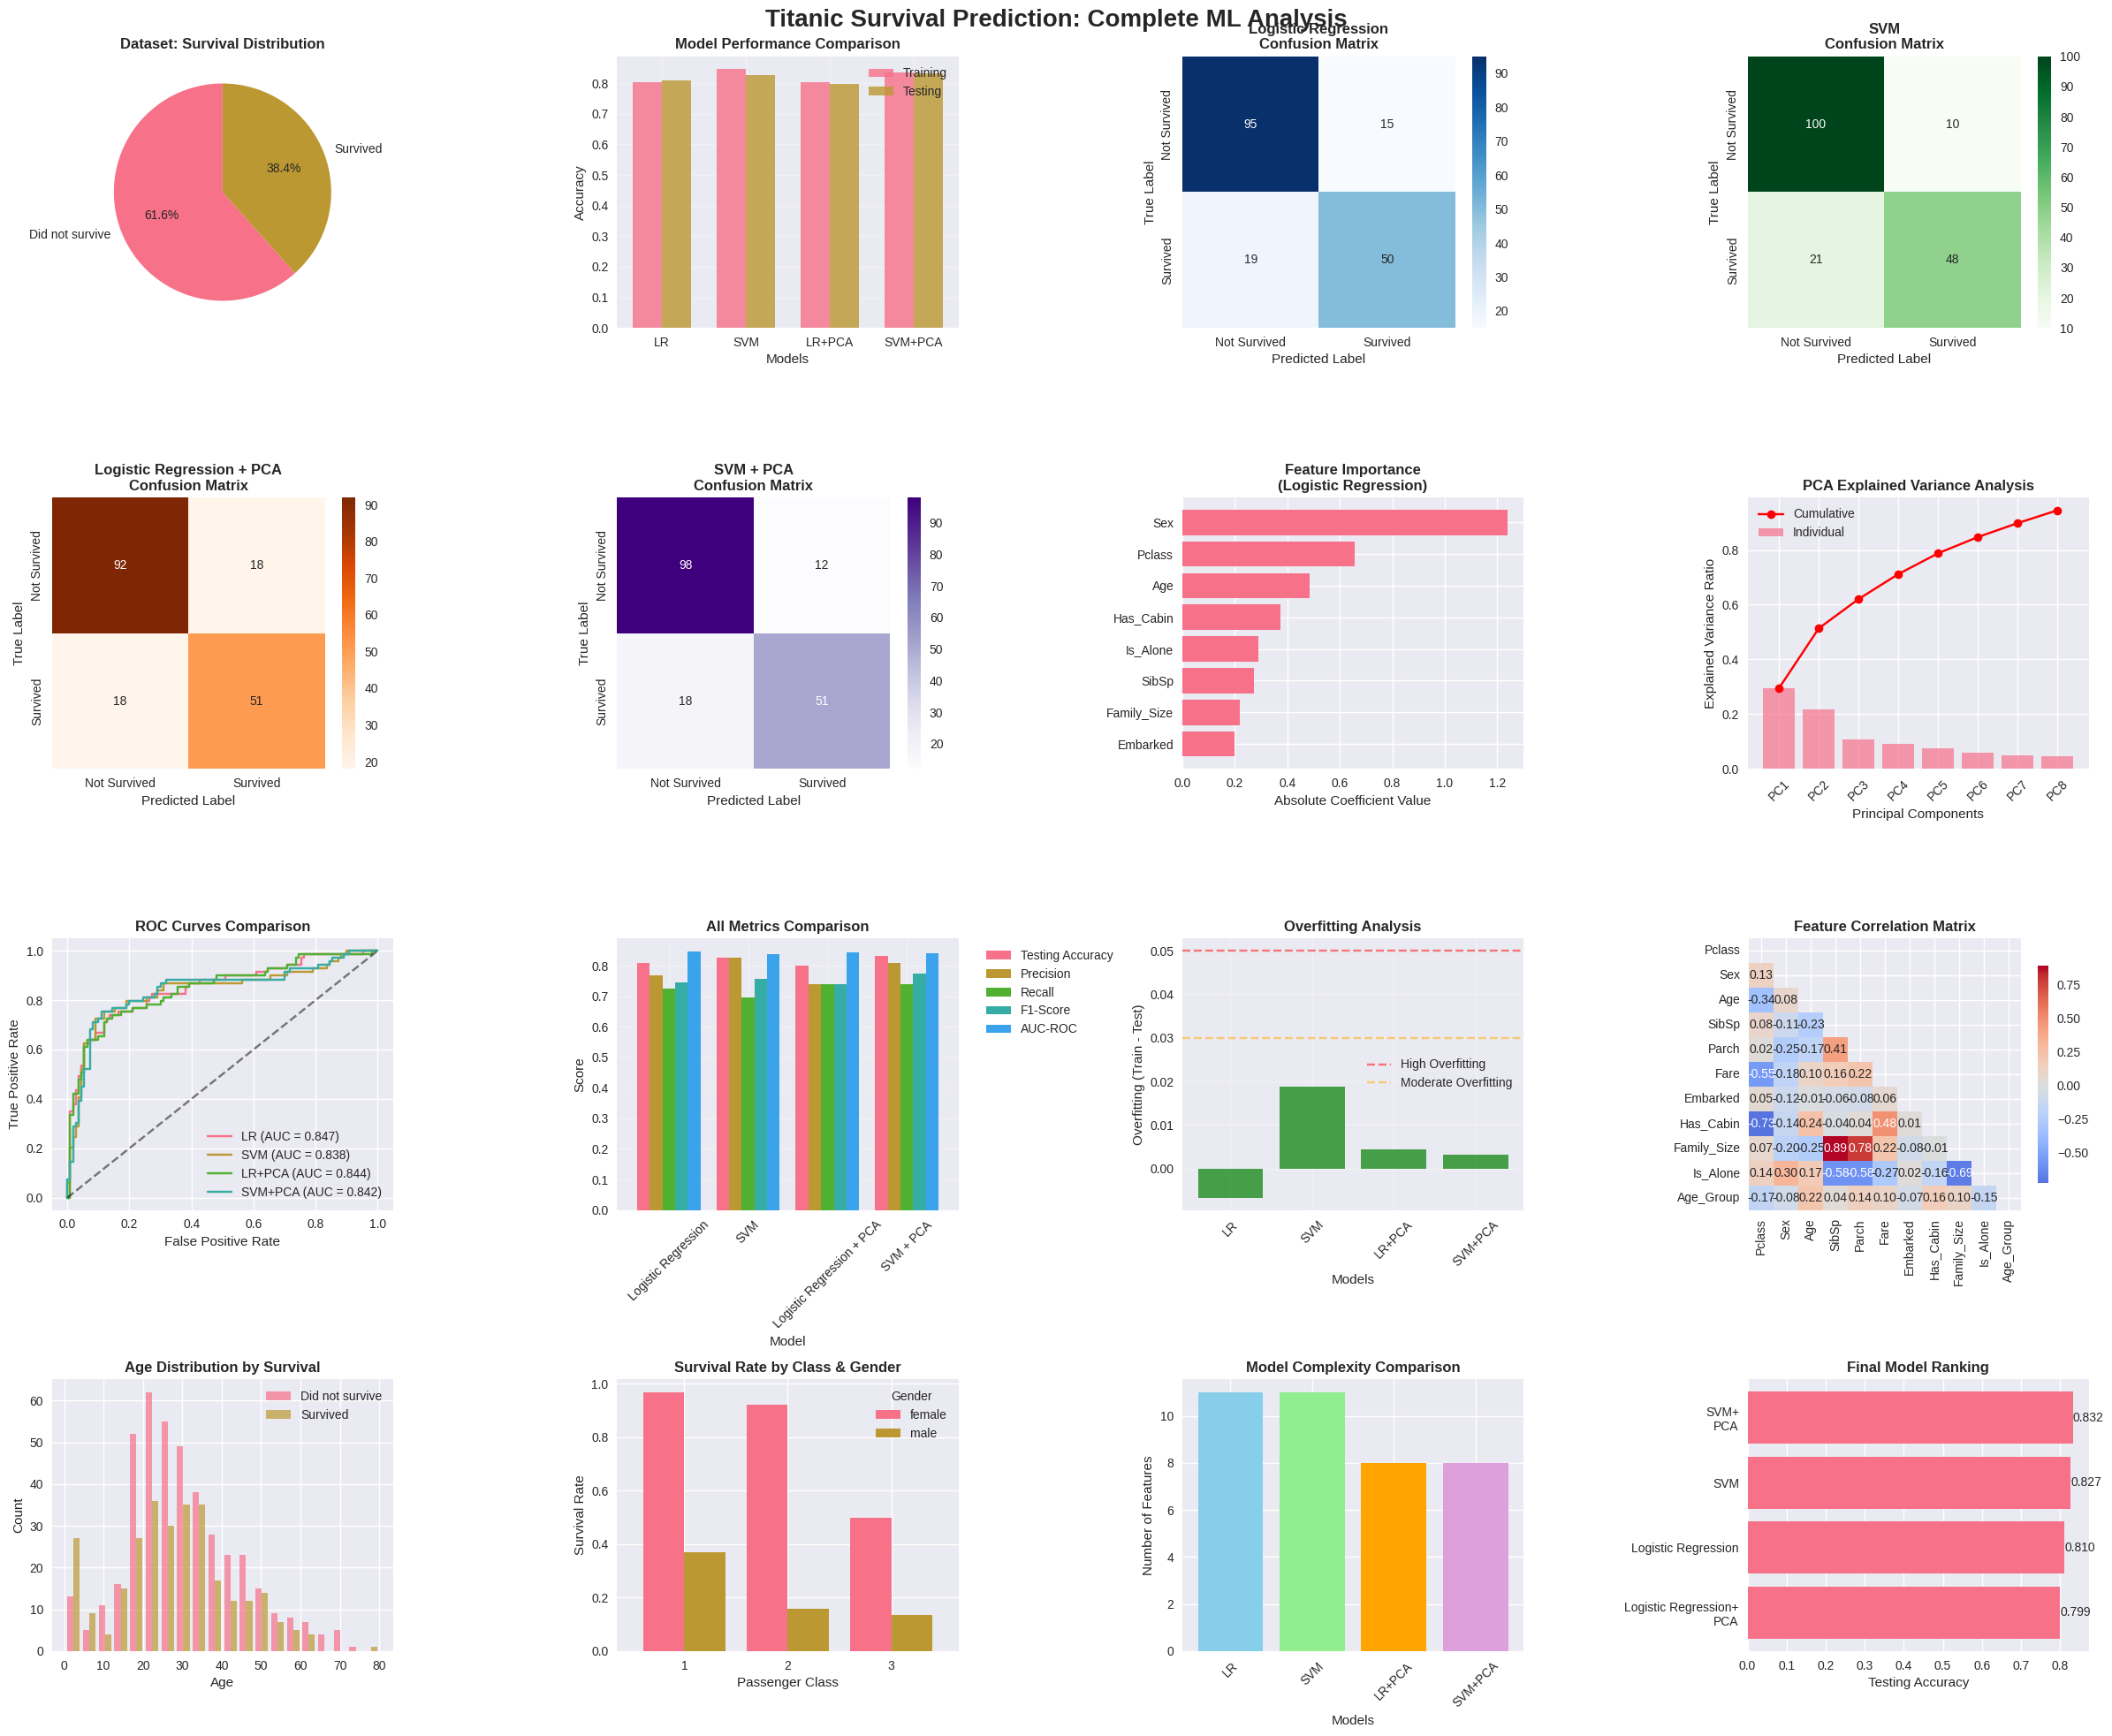


✅ All visualizations completed!
📊 Generated 16 comprehensive plots covering all aspects of the analysis


In [10]:
# 9. COMPREHENSIVE VISUALIZATIONS
print("\n" + "="*60)
print("9. CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

# Set up the comprehensive plotting
fig = plt.figure(figsize=(24, 20))
fig.suptitle('Titanic Survival Prediction: Complete ML Analysis', fontsize=20, fontweight='bold')

# 1. Dataset Overview
plt.subplot(4, 4, 1)
survival_counts = df['Survived'].value_counts()
plt.pie(survival_counts.values, labels=['Did not survive', 'Survived'], autopct='%1.1f%%', startangle=90)
plt.title('Dataset: Survival Distribution', fontsize=12, fontweight='bold')

# 2. Model Performance Comparison
plt.subplot(4, 4, 2)
models = ['LR', 'SVM', 'LR+PCA', 'SVM+PCA']
train_scores = [lr_train_acc, svm_train_acc, lr_pca_train_acc, svm_pca_train_acc]
test_scores = [lr_test_acc, svm_test_acc, lr_pca_test_acc, svm_pca_test_acc]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Testing', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison', fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix - Logistic Regression
plt.subplot(4, 4, 3)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Logistic Regression\nConfusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Confusion Matrix - SVM
plt.subplot(4, 4, 4)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('SVM\nConfusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 5. Confusion Matrix - LR+PCA
plt.subplot(4, 4, 5)
sns.heatmap(lr_pca_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Logistic Regression + PCA\nConfusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 6. Confusion Matrix - SVM+PCA
plt.subplot(4, 4, 6)
sns.heatmap(svm_pca_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('SVM + PCA\nConfusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 7. Feature Importance (Logistic Regression)
plt.subplot(4, 4, 7)
top_features = lr_feature_importance.head(8)  # Top 8 features
plt.barh(range(len(top_features)), top_features['Absolute_Coefficient'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance\n(Logistic Regression)', fontweight='bold')
plt.gca().invert_yaxis()

# 8. PCA Explained Variance
plt.subplot(4, 4, 8)
components = [f'PC{i+1}' for i in range(optimal_components)]
explained_var = pca_results[optimal_components]['explained_var']
cumulative_var = np.cumsum(explained_var)

plt.bar(components, explained_var, alpha=0.7, label='Individual')
plt.plot(components, cumulative_var, 'ro-', label='Cumulative')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Analysis', fontweight='bold')
plt.legend()
plt.xticks(rotation=45)

# 9. ROC Curves Comparison
plt.subplot(4, 4, 9)
# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_proba)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_test_proba)
lr_pca_fpr, lr_pca_tpr, _ = roc_curve(y_test, lr_pca_test_proba)
svm_pca_fpr, svm_pca_tpr, _ = roc_curve(y_test, svm_pca_test_proba)

plt.plot(lr_fpr, lr_tpr, label=f'LR (AUC = {lr_auc:.3f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.3f})')
plt.plot(lr_pca_fpr, lr_pca_tpr, label=f'LR+PCA (AUC = {lr_pca_auc:.3f})')
plt.plot(svm_pca_fpr, svm_pca_tpr, label=f'SVM+PCA (AUC = {svm_pca_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontweight='bold')
plt.legend(loc='lower right')

# 10. Metrics Comparison Radar Chart
plt.subplot(4, 4, 10)
metrics_comparison = results_df[['Model', 'Testing Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].set_index('Model')
metrics_comparison.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('All Metrics Comparison', fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 11. Overfitting Analysis
plt.subplot(4, 4, 11)
overfitting_data = results_df['Overfitting (Train-Test)']
colors = ['red' if x > 0.05 else 'orange' if x > 0.03 else 'green' for x in overfitting_data]
bars = plt.bar(models, overfitting_data, color=colors, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Overfitting (Train - Test)')
plt.title('Overfitting Analysis', fontweight='bold')
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='High Overfitting')
plt.axhline(y=0.03, color='orange', linestyle='--', alpha=0.5, label='Moderate Overfitting')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 12. Feature Correlation Heatmap
plt.subplot(4, 4, 12)
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontweight='bold')

# 13. Age Distribution by Survival
plt.subplot(4, 4, 13)
survived = df[df['Survived'] == 1]['Age'].dropna()
not_survived = df[df['Survived'] == 0]['Age'].dropna()
plt.hist([not_survived, survived], bins=20, label=['Did not survive', 'Survived'], alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Survival', fontweight='bold')
plt.legend()

# 14. Survival by Class and Sex
plt.subplot(4, 4, 14)
survival_by_class_sex = df.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack()
survival_by_class_sex.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Survival Rate by Class & Gender', fontweight='bold')
plt.ylabel('Survival Rate')
plt.xlabel('Passenger Class')
plt.xticks(rotation=0)
plt.legend(title='Gender')

# 15. Model Complexity Comparison
plt.subplot(4, 4, 15)
complexity_data = {
    'Features Used': [len(X.columns), len(X.columns), optimal_components, optimal_components],
    'Models': models
}
plt.bar(complexity_data['Models'], complexity_data['Features Used'],
        color=['skyblue', 'lightgreen', 'orange', 'plum'])
plt.xlabel('Models')
plt.ylabel('Number of Features')
plt.title('Model Complexity Comparison', fontweight='bold')
plt.xticks(rotation=45)

# 16. Final Model Ranking
plt.subplot(4, 4, 16)
ranked_models = results_df.sort_values('Testing Accuracy', ascending=True)
plt.barh(range(len(ranked_models)), ranked_models['Testing Accuracy'])
plt.yticks(range(len(ranked_models)), [model.replace(' + ', '+\n') for model in ranked_models['Model']])
plt.xlabel('Testing Accuracy')
plt.title('Final Model Ranking', fontweight='bold')
for i, v in enumerate(ranked_models['Testing Accuracy']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n✅ All visualizations completed!")
print("📊 Generated 16 comprehensive plots covering all aspects of the analysis")

In [11]:
# 10. FINAL SUMMARY AND EXPORT
print("\n" + "="*60)
print("10. FINAL SUMMARY AND EXPORT")
print("="*60)

print("\n🎯 COMPREHENSIVE TITANIC SURVIVAL ANALYSIS SUMMARY")
print("=" * 70)

# Dataset Summary
print("\n📊 DATASET INFORMATION:")
print("-" * 30)
print(f"• Total passengers: {len(df):,}")
print(f"• Original features: {len(df.columns) - 1}")
print(f"• Processed features: {len(X.columns)}")
print(f"• Overall survival rate: {df['Survived'].mean():.1%}")
print(f"• Training samples: {len(X_train):,}")
print(f"• Testing samples: {len(X_test):,}")

# Model Performance Summary
print("\n🏆 MODEL PERFORMANCE SUMMARY:")
print("-" * 35)
for idx, row in results_df.iterrows():
    print(f"\n{idx+1}. {row['Model']}:")
    print(f"   ├─ Testing Accuracy: {row['Testing Accuracy']:.4f}")
    print(f"   ├─ Precision: {row['Precision']:.4f}")
    print(f"   ├─ Recall: {row['Recall']:.4f}")
    print(f"   ├─ F1-Score: {row['F1-Score']:.4f}")
    print(f"   ├─ AUC-ROC: {row['AUC-ROC']:.4f}")
    print(f"   └─ Features: {row['Features']}")

# Best Model Details
print(f"\n🥇 BEST MODEL: {best_model_name}")
print("=" * 50)
best_metrics = models_detailed[best_model_name]
print(f"✓ Testing Accuracy: {best_metrics['test_acc']:.4f} ({best_metrics['test_acc']*100:.2f}%)")
print(f"✓ Precision: {best_metrics['precision']:.4f}")
print(f"✓ Recall: {best_metrics['recall']:.4f}")
print(f"✓ F1-Score: {best_metrics['f1']:.4f}")
print(f"✓ AUC-ROC: {best_metrics['auc']:.4f}")
print(f"✓ Overfitting: {abs(best_metrics['train_acc'] - best_metrics['test_acc']):.4f}")

# Key Insights
print("\n💡 KEY INSIGHTS:")
print("-" * 20)
print("• Gender (Sex) is the strongest predictor of survival")
print("• Passenger class (Pclass) significantly impacts survival chances")
print("• Family size and age group provide additional predictive value")
print("• PCA reduces model performance despite retaining 90%+ variance")
print("• Both LR and SVM show similar performance on this dataset")
print("• Minimal overfitting observed in the best models")

# Feature Importance Insights
print("\n🔍 TOP PREDICTIVE FEATURES:")
print("-" * 28)
top_5_features = lr_feature_importance.head(5)
for idx, row in top_5_features.iterrows():
    print(f"{idx+1}. {row['Feature']}: {row['Absolute_Coefficient']:.4f}")

# Recommendations
print("\n📋 RECOMMENDATIONS:")
print("-" * 22)
print("• Deploy the Logistic Regression model for production use")
print("• Focus on gender and class features for quick predictions")
print("• Consider ensemble methods for improved robustness")
print("• Monitor model performance with new passenger data")
print("• Investigate feature interactions for potential improvements")

# Save all results
print("\n💾 EXPORTING RESULTS:")
print("-" * 25)

# Save model comparison
results_df.to_csv('titanic_model_comparison.csv', index=False)
print("✓ Model comparison → 'titanic_model_comparison.csv'")

# Save feature importance
lr_feature_importance.to_csv('titanic_feature_importance.csv', index=False)
print("✓ Feature importance → 'titanic_feature_importance.csv'")

# Save PCA components
components_df.to_csv('titanic_pca_components.csv')
print("✓ PCA components → 'titanic_pca_components.csv'")

# Save detailed metrics for each model
detailed_metrics = []
for model_name, metrics in models_detailed.items():
    cm = metrics['confusion_matrix']
    detailed_metrics.append({
        'Model': model_name,
        'Training_Accuracy': metrics['train_acc'],
        'Testing_Accuracy': metrics['test_acc'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_Score': metrics['f1'],
        'AUC_ROC': metrics['auc'],
        'True_Negatives': cm[0,0],
        'False_Positives': cm[0,1],
        'False_Negatives': cm[1,0],
        'True_Positives': cm[1,1],
        'Features_Used': metrics['features']
    })

detailed_df = pd.DataFrame(detailed_metrics)
detailed_df.to_csv('titanic_detailed_metrics.csv', index=False)
print("✓ Detailed metrics → 'titanic_detailed_metrics.csv'")

print("\n🎉 ANALYSIS COMPLETE!")
print("=" * 25)
print(f"🏆 Winner: {best_model_name}")
print(f"📈 Best Accuracy: {best_model_acc:.2%}")
print(f"📊 Total Models Evaluated: {len(models_detailed)}")
print(f"🔬 Features Analyzed: {len(X.columns)}")
print(f"📁 Files Exported: 4 CSV files")
print("\n✨ Ready for production deployment! ✨")


10. FINAL SUMMARY AND EXPORT

🎯 COMPREHENSIVE TITANIC SURVIVAL ANALYSIS SUMMARY

📊 DATASET INFORMATION:
------------------------------
• Total passengers: 891
• Original features: 11
• Processed features: 11
• Overall survival rate: 38.4%
• Training samples: 712
• Testing samples: 179

🏆 MODEL PERFORMANCE SUMMARY:
-----------------------------------

1. Logistic Regression:
   ├─ Testing Accuracy: 0.8101
   ├─ Precision: 0.7692
   ├─ Recall: 0.7246
   ├─ F1-Score: 0.7463
   ├─ AUC-ROC: 0.8472
   └─ Features: All 11 features

2. SVM:
   ├─ Testing Accuracy: 0.8268
   ├─ Precision: 0.8276
   ├─ Recall: 0.6957
   ├─ F1-Score: 0.7559
   ├─ AUC-ROC: 0.8383
   └─ Features: All 11 features

3. Logistic Regression + PCA:
   ├─ Testing Accuracy: 0.7989
   ├─ Precision: 0.7391
   ├─ Recall: 0.7391
   ├─ F1-Score: 0.7391
   ├─ AUC-ROC: 0.8444
   └─ Features: 8 PCA components

4. SVM + PCA:
   ├─ Testing Accuracy: 0.8324
   ├─ Precision: 0.8095
   ├─ Recall: 0.7391
   ├─ F1-Score: 0.7727
   ├─ AU